<a href="https://colab.research.google.com/github/Kaderbalde/Reinforcement_Learning/blob/main/correction_policy_iteration_value_iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dakar Institute of Technology

# Reinforcement Learning: Policy and Value Iteration Lab




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preparing the Colab Environment

The cell below installs gymnasium and downloads rltools to the virtual machine.

In [2]:
%%capture
!pip install gymnasium==0.28.1
!rm rltools -r
!git clone https://github.com/drbeane/rltools.git

The cell below includes the import statements for this lab.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import rltools
import rltools.gym as gym
from rltools.utils import evaluate, create_gif
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

## Part 0: Policy Iteration and Value Iteration

In [4]:
class DPAgent:

    def __init__(self, env, gamma=1.0, policy=None, seed=None):
        import numpy as np

        #--------------------------------------------------------
        # Store environment and gamma.
        #--------------------------------------------------------
        self.env = env
        self.gamma = gamma

        #--------------------------------------------------------
        # Get state information from environment.
        #--------------------------------------------------------
        self.states = self.env.get_states()
        self.num_states = env.observation_space.n

        #--------------------------------------------------------
        # Get environment information from environment.
        #--------------------------------------------------------
        self.num_actions = env.action_space.n
        self.actions = range(self.num_actions)

        #--------------------------------------------------------
        # Store policy or generate a random policy.
        #--------------------------------------------------------
        if policy is None:
            np_state = set_np_seed(seed)
            self.policy = {s:np.random.choice(self.actions) for s in self.states}
            restore_np_state(np_state)
        else:
            self.policy = policy

        #--------------------------------------------------------
        # Initialize value functions to zero
        #--------------------------------------------------------
        self.Q = {s:np.zeros(self.num_actions) for s in self.states}
        self.V = {s:0 for s in self.states}


    def select_action(self, state):
        return self.policy[state]

    def policy_evaluation(
        self, threshold=1e-6, max_iter=None, verbose=True, return_n=False):
        '''
        Evaluates the policy currently attached to the agent.
        '''

        #--------------------------------------------------------
        # Loop for max_iter iteratons, or until convergence.
        #--------------------------------------------------------
        if max_iter is None:
            max_iter = float('inf')
        n = 0
        while n < max_iter:
            n += 1

            #--------------------------------------------------------
            # Copy current V.
            #--------------------------------------------------------
            V_old = self.V.copy()

            #--------------------------------------------------------
            # Loop over all states
            # Calculate new V(s) for each s
            #--------------------------------------------------------
            for s in self.states:

                # Select action and then get transitions P(s,a)
                a = self.policy[s]
                transitions = self.env.P[s][a]

                # Loop over all transitions
                Vs = 0
                for prob, s_, reward, done in transitions:
                    G_estimate = reward + (0 if done else self.gamma * V_old[s_])
                    Vs += prob * G_estimate
                self.V[s] = Vs

            #--------------------------------------------------------
            # Check for convergence
            #--------------------------------------------------------
            max_diff = max([abs(self.V[s] - V_old[s]) for s in self.states])
            if max_diff < threshold:
                break

        if verbose:
            print(f'Policy evaluation required {n} iterations to converge.')

        if return_n:
            return n

    def calculate_Q(self):
        '''
        Calculates estimate of Q from current estimate of V
        '''
        for s in self.states:
            for a in self.actions:
                trans = self.env.P[s][a]
                Qsa = 0
                for prob, s_, reward, done in trans:
                    G_est = reward + (0 if done else self.gamma * self.V[s_])
                    Qsa += prob * G_est
                self.Q[s][a] = Qsa


    def policy_improvement(self):
        '''
        Uses Q est to perform greedy policy improvement on cur policy.
        Assumes that Q and V have been estimated for policy.
        '''
        import numpy as np
        self.calculate_Q()
        self.policy = {s:np.argmax(self.Q[s]) for s in self.states}


    def policy_iteration(self, threshold=1e-6, verbose=True):

        #----------------------------------------------------------
        # Loop until convergence of policy
        #----------------------------------------------------------
        n = 0
        num_eval_steps = 0
        while True:
            n += 1

            # Store current policy
            old_policy = self.policy.copy()

            # Value current policy
            num_eval_steps += self.policy_evaluation(
                threshold=threshold, max_iter=None, return_n=True, verbose=False)

            # Policy Improvement
            self.policy_improvement()
            #self.calculate_Q()

            # Check for convergence
            if old_policy == self.policy:
                break

        #----------------------------------------------------------
        # Print report
        #----------------------------------------------------------
        if verbose:
            print(f'Policy iteration required {n} steps to converge.')
            print(f'{num_eval_steps} steps of policy evaluation were performed.')


    def value_iteration(self, threshold=1e-6, verbose=True):
        import numpy as np

        #----------------------------------------------------------
        # Loop until convergence of value function
        #----------------------------------------------------------
        n = 0
        while True:
            n += 1

            # Store current V estimate
            V_old = self.V.copy()

            # Get Q from current V
            self.calculate_Q()


            # Determine new V from Q
            self.V = {s:np.max(self.Q[s]) for s in self.states}

            # Check for convergence
            max_diff = max([abs(self.V[s] - V_old[s]) for s in self.states])
            if max_diff < threshold:
                break


        #----------------------------------------------------------
        # Determine Optimal Policy
        #----------------------------------------------------------
        self.calculate_Q()
        self.policy = {s:np.argmax(self.Q[s]) for s in self.states}

        #----------------------------------------------------------
        # Display report
        #----------------------------------------------------------
        if verbose:
            print(f'Value iteration required {n} steps to converge.')

def set_np_seed(seed):
    import numpy as np
    if seed is None: return None
    np_state = np.random.get_state()
    np.random.seed(seed)
    return np_state

def restore_np_state(np_state):
    import numpy as np
    if np_state is None: return
    np.random.set_state(np_state)



# Part 1 - Policy Evaluation: 4x4 Frozen Lake

In Part 1 of this lab, I use policy evaluation to evalute two policies for the Frozen Lake environment.

## 1.A - Create Environment

Start by creating an instance of the `'FrozenLake-v1'` with `prob=0.8` and using `matplotlib` to display the environment (without axes).

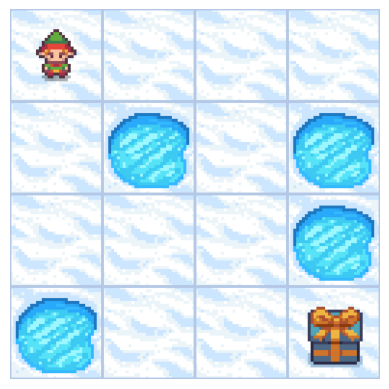

In [5]:
# Create the environment
fl = gym.make(
    name = 'FrozenLake-v1',
    prob = 0.8,
    render_mode = 'rgb_array',
)

# Reset the environment
state, info = fl.reset(seed=1)

# Plot the environment
fl.render()
plt.imshow(fl.render())
plt.axis('off')
plt.show()

## 1.B - Define Random Policy

Randomly generate a policy for the Frozen Lake environment and display this policy using the `display_policy()` method of the environment.

In [6]:
np.random.seed(1)
random_policy = {s:np.random.choice(4) for s in range(16)}

# Display the policy
fl.display_policy(random_policy)

+---+---+---+---+
| S | ↑ | ← | ← |
+---+---+---+---+
| ↑ | H | ↑ | H |
+---+---+---+---+
| ↑ | ← | ← | H |
+---+---+---+---+
| H | ↑ | ↓ | G |
+---+---+---+---+



## 1.C - Policy Evaluation for Random Policy

We perform policy evaluation for the random policy by creating an instance of `DPAgent`, calling the policy evaluation method, and calling the `display_values()` method, passing it the state-value function calculated by the agent.   

In [7]:
# Create an instance of DPAgent
dp_agent_random = DPAgent(env=fl, gamma=1.0, policy=random_policy)

# Perform policy evaluation
dp_agent_random.policy_evaluation()

# Display state-value function
fl.display_values(dp_agent_random.V)

Policy evaluation required 57 iterations to converge.


0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0
0.001,0.006,0.058,0.0
0.0,0.058,0.529,0.0


## 1.D - Success Rate for Random Policy

Next, We use the `evaluate()` function to evaluate the performance of the agent from 1.C on the environment, using the following parameters: `episodes=1000`, `seed=1`, `gamma=1.0`, and `check_sucess=True`.


In [8]:
# Evaluate the agent's performance
fl_random_policy_evaluation_results = evaluate(fl, dp_agent_random, episodes=1000, gamma=1.0, seed=1, check_success=True)

Mean Return:    0.0
StdDev Return:  0.0
Mean Length:    31.779
StdDev Length:  34.4514
Success Rate:   0.0


## 1.E - Define Custom Policy

In the cell below, We have created a custom policy, directing the agent to move toward the goal as quickly as possible, and displayed this policy using the `display_policy()` method of the environment.

In [9]:
custom_policy = {
    0:1, 1:2, 2:1, 3:0, 4:1, 5:0, 6:1, 7:0,
    8:2, 9:1, 10:1, 11:0, 12:0, 13:2, 14:2, 15:0
}

# Display the custom policy
fl.display_policy(custom_policy)

+---+---+---+---+
| S | → | ↓ | ← |
+---+---+---+---+
| ↓ | H | ↓ | H |
+---+---+---+---+
| → | ↓ | ↓ | H |
+---+---+---+---+
| H | → | → | G |
+---+---+---+---+



## 1.G - Policy Evaluation for Custom Policy

Now, We will create a new instance of `DPAgent` and perform policy evaluation for the custom policy.

In [10]:
# Create a new instance of DPAgent with the custom policy
dp_agent_custom = DPAgent(env=fl, gamma=1.0, policy=custom_policy)

# Perform policy evaluation for the custom policy
dp_agent_custom.policy_evaluation()

# Display state-value function for the custom policy
fl.display_values(dp_agent_custom.V)

Policy evaluation required 28 iterations to converge.


0.734,0.613,0.69,0.613
0.75,0.0,0.709,0.0
0.843,0.96,0.886,0.0
0.0,0.984,0.987,0.0


## 1.F - Success Rate for Custom Policy

Next, We evaluate the performance of the custom policy.

In [11]:
# Evaluate the agent's performance for custom policy
fl_custom_policy_evaluation_results = evaluate(fl, dp_agent_custom, episodes=1000, gamma=1.0, seed=1, check_success=True)

Mean Return:    0.733
StdDev Return:  0.4424
Mean Length:    6.423
StdDev Length:  2.5495
Success Rate:   0.733


## 1.H - Sample Episode under Custom Policy

Finally, We create a gif demonstrating the custom agent's behavior.

8 steps completed.
Cumulative reward: 1
Success


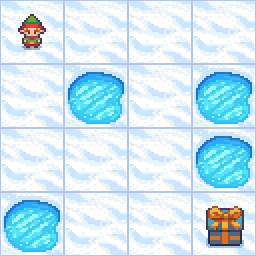

In [12]:
# Create a gif demonstrating the custom agent's behavior
create_gif(fl, dp_agent_custom, folder='gifs', filename='frozen_lake_01', seed=1)

# Part 2 - Control Methods for 4x4 Frozen Lake

In Part 2, We apply the dynamic programming control methods to find an optimal policy for the environment created in Part 1.

### 2.A - Policy Iteration

We start by applying policy iteration by creating an instance of `DPAgent`, calling the `policy_iteration()` method, and displaying the optimal policy found by policy iteration.

In [13]:
# Create an instance of DPAgent
dp_agent_policy_iteration = DPAgent(env=fl, gamma=1.0, seed=1)

# Call the policy_iteration() method
dp_agent_policy_iteration.policy_iteration()

# Display the optimal policy found through policy iteration
fl.display_policy(dp_agent_policy_iteration.policy)

Policy iteration required 7 steps to converge.
2338 steps of policy evaluation were performed.
+---+---+---+---+
| S | ↑ | ↑ | ↑ |
+---+---+---+---+
| ← | H | ↑ | H |
+---+---+---+---+
| ↑ | ↓ | ← | H |
+---+---+---+---+
| H | → | ↓ | G |
+---+---+---+---+



## 2.B - Value Iteration

We now apply value iteration by creating a new instance of `DPAgent`, calling the `value_iteration()` method, and displaying the optimal policy found by value iteration.

In [14]:
# Create an instance of DPAgent
dp_agent_value_iteration = DPAgent(env=fl, gamma=1.0, seed=1)

# Call the value_iteration() method
dp_agent_value_iteration.value_iteration()

# Display the optimal policy found through value iteration
fl.display_policy(dp_agent_value_iteration.policy)

Value iteration required 1320 steps to converge.
+---+---+---+---+
| S | ↑ | ↑ | ↑ |
+---+---+---+---+
| ← | H | ↑ | H |
+---+---+---+---+
| ↑ | ↓ | ← | H |
+---+---+---+---+
| H | → | ↓ | G |
+---+---+---+---+



Note that the two control methods find the same optimal policy, but value iteration required significantly fewer policy evaluation steps. Additionally, this policy is much less direct than the custom policy created in Step 1.E.

## 2.C - Performance of Optimal Policy

 Next, We calcualte the success rate under the optimal policy, using the `evaluate()` function.

In [15]:
# Evaluate the agent's performance under the optimal policy obtained through policy iteration
results = evaluate(env=fl, agent=dp_agent_policy_iteration, episodes=1000, gamma=1.0, seed=1, check_success=True)

Mean Return:    0.992
StdDev Return:  0.0891
Mean Length:    186.322
StdDev Length:  178.4541
Success Rate:   0.992


The optimal policy has a much higher success rate than the direct policy from Step 1.E, but it also results in very long episodes.

## 2.D - State-Value Function for Optimal Policy

Display the state-value function for the optimal policy using the `display_values()` method of the environment.

In [16]:
# Display the state-value function for the optimal policy found through policy iteration
fl.display_values(dp_agent_policy_iteration.V)

0.997,0.997,0.997,0.997
0.997,0.0,0.797,0.0
0.997,0.997,0.977,0.0
0.0,0.999,1.0,0.0


## 2.E - Sample Episode under Optimal Policy

Finally, We create a gif demonstrating the agent's behavior under the optimal policy.

69 steps completed.
Cumulative reward: 1
Success


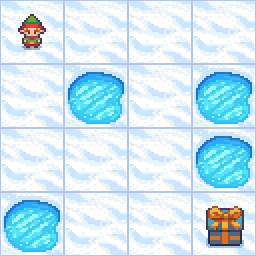

In [17]:
# Create a gif demonstrating the agent's behavior under the optimal policy found through policy iteration
create_gif(fl, dp_agent_policy_iteration, folder='gifs', filename='frozen_lake_02', seed=1)

# Part 3 - 32x32 Frozen Lake

We now apply value iteration to a much larger version of the Frozen Lake environment.

## 3.A - Create and Display Environment

We create a 32x32 version of the Frozen Lake environment with a custom reward structure.

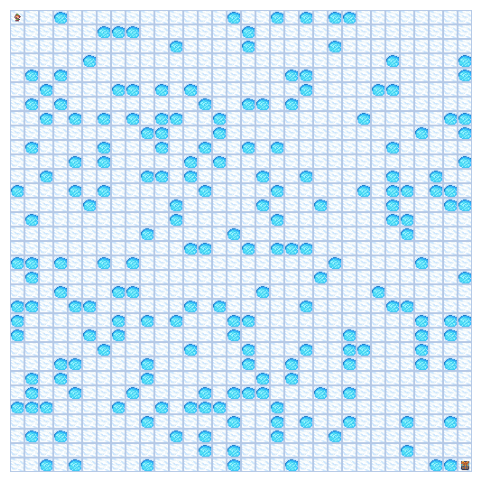

In [18]:
env4 = gym.make(
    'FrozenLake-v1',
    prob = 0.9,
    rew_struct = [-0.1, -10, 100],
    desc = generate_random_map(size=32, p=0.8, seed=8),
    max_episode_steps = 1000,
    render_mode = 'rgb_array'
)

obs, info = env4.reset()
plt.figure(figsize=[6,6])
plt.imshow(env4.render())
plt.axis('off')
plt.show()

In [19]:
# Create an instance of DPAgent with the optimal time penalty for the 32x32 environment
dp_agent_optimal_32 = DPAgent(env=env4, gamma=1.0, seed=1)

# Run value iteration for this optimized environment
dp_agent_optimal_32.policy_iteration()

# Evaluate the agent's performance with the optimal time penalty in the 32x32 environment
results_optimal_32 = evaluate(env=env4, agent=dp_agent_optimal_32,
                              episodes=1000, gamma=1.0, seed=1, check_success=True)

Policy iteration required 24 steps to converge.
90512 steps of policy evaluation were performed.
Mean Return:    78.924
StdDev Return:  23.2152
Mean Length:    146.86
StdDev Length:  61.4405
Success Rate:   0.941


230 steps completed.
Cumulative reward: 77.1
Success


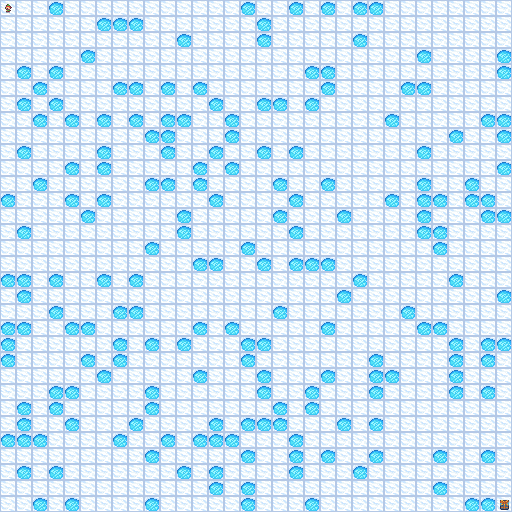

In [ ]:
# Create a gif demonstrating the agent's behavior under the optimal policy in the 32x32 environment
create_gif(env4, dp_agent_optimal_32, folder='gifs', filename='frozen_lake_02', seed=1)